# Process seismic waveforms

An essential step toward the procedure is to correctly process the seismic data. Pre-processing must depend on the dataset and cannot be generalized easily. A thorough pre-processing chain would also be overkill for good-quality datasets. The pre-processing stages shown in this notebook are given as an example, although the toy dataset is of relatively good quality.

In [1]:
import glob
import obspy
import os
import tqdm

## Path

First, define the path from which to read the raw data and save the processed data.

In [2]:
DIRPATH_RAW = "../data/"
DIRPATH_PROCESSED = "../data_processed/"

# Create the repository if needed
if not os.path.isdir(DIRPATH_PROCESSED):
    os.mkdir(DIRPATH_PROCESSED)

## List of files

Get a list of all available waveforms to process.

In [3]:
filepaths_waveforms = glob.glob(os.path.join(DIRPATH_RAW, "*mseed"))

## Show an example raw trace

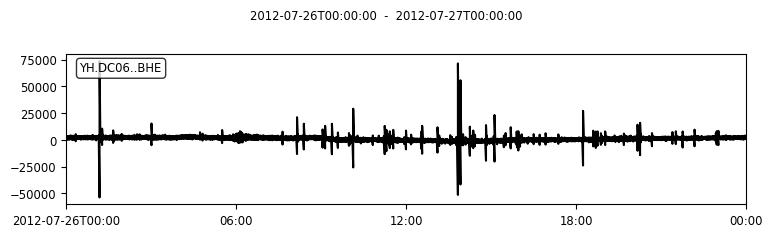

In [4]:
stream = obspy.read(filepaths_waveforms[0])
stream.plot(show=False)

## Process

This stage load every waveform and apply the processing chain, including a detrend on individual segments (if any), a merge and gap filling over the full day (between the start and end time of the trace), a resampling at a target sampling rate and a sensitivity removal. Overall, this cell executes in about 3 minutes on a desktop machine.

In [9]:
SAMPLING_RATE = 25.0
MAX_SEGMENTS = 10
TAPER_PERCENT = 0.05
TAPER_TYPE = "cosine"
ENCODING = "FLOAT64"

for filepath_waveform in tqdm.tqdm(
    filepaths_waveforms, desc="Processing data"
):

    # Read trace
    stream = obspy.read(filepath_waveform)
    trace = stream[0]

    # Collect start and end times
    starttime, endtime = trace.stats.starttime, trace.stats.endtime

    # Split trace into segments
    trace = trace.split()

    # Apply detrend on segments
    trace.detrend("constant")
    trace.detrend("linear")
    trace.taper(TAPER_PERCENT, type=TAPER_TYPE)

    # Merge traces back and fill gaps
    trace = trace.merge(fill_value=0.0)
    trace = trace[0]
    trace.trim(starttime=starttime, endtime=endtime, pad=True, fill_value=0.0)

    # Resample
    trace.resample(SAMPLING_RATE)

    # Attach response
    filepath_inventory = f"{trace.stats.network}.{trace.stats.station}.xml"
    filepath_inventory = os.path.join(DIRPATH_RAW, filepath_inventory)
    inventory = obspy.read_inventory(filepath_inventory)
    trace.attach_response(inventory)

    # Remove response
    trace.remove_sensitivity()

    # Detrend
    trace.detrend("constant")
    trace.detrend("linear")
    trace.taper(0.02, type="cosine")

    # Filter
    trace.filter("highpass", freq=2.0, zerophase=True)
    trace.filter("lowpass", freq=12.0, zerophase=True)
    trace.taper(0.02, type="cosine")

    # Write processed traces
    _, filename = os.path.split(filepath_waveform)
    filepath_processed_waveform = os.path.join(DIRPATH_PROCESSED, filename)
    trace.write(filepath_processed_waveform, encoding=ENCODING)


Processing data: 100%|██████████| 24/24 [01:05<00:00,  2.71s/it]


## Compare raw and processed traces

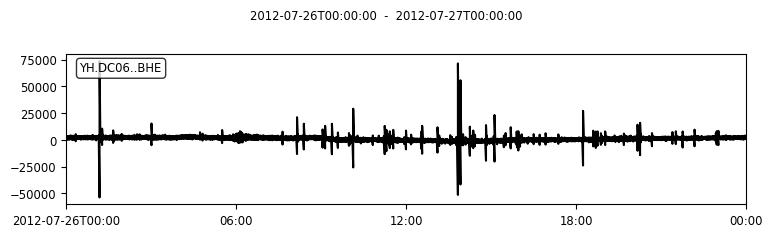

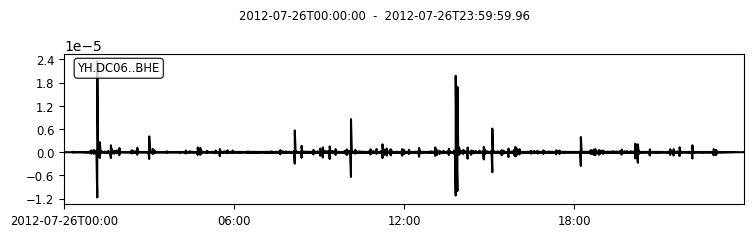

In [10]:
# Get same raw and processed filepaths
filepath_waveform = filepaths_waveforms[0]
_, filename = os.path.split(filepath_waveform)
filepath_waveform_processed = os.path.join(DIRPATH_PROCESSED, filename)

# Read
for filepath in (filepath_waveform, filepath_waveform_processed):
    stream = obspy.read(filepath)
    stream.plot(transparent=True)